# 1. TẢI THƯ VIỆN

In [1]:
!pip install torchio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.5 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import gc
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import nibabel as nib
import imageio
from skimage.transform import resize
from skimage.util import montage
from skimage.measure import label

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.graph_objects as go
import plotly.offline as pyo

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchio as tio

import wandb

In [3]:
wandb.login(key='df16e8b7e5b6e7158d36108e95e825eb0c214eda')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 23020434 (23020434-university-of-engineering-and-technology-vnu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# 2. HIỂU DỮ LIỆU

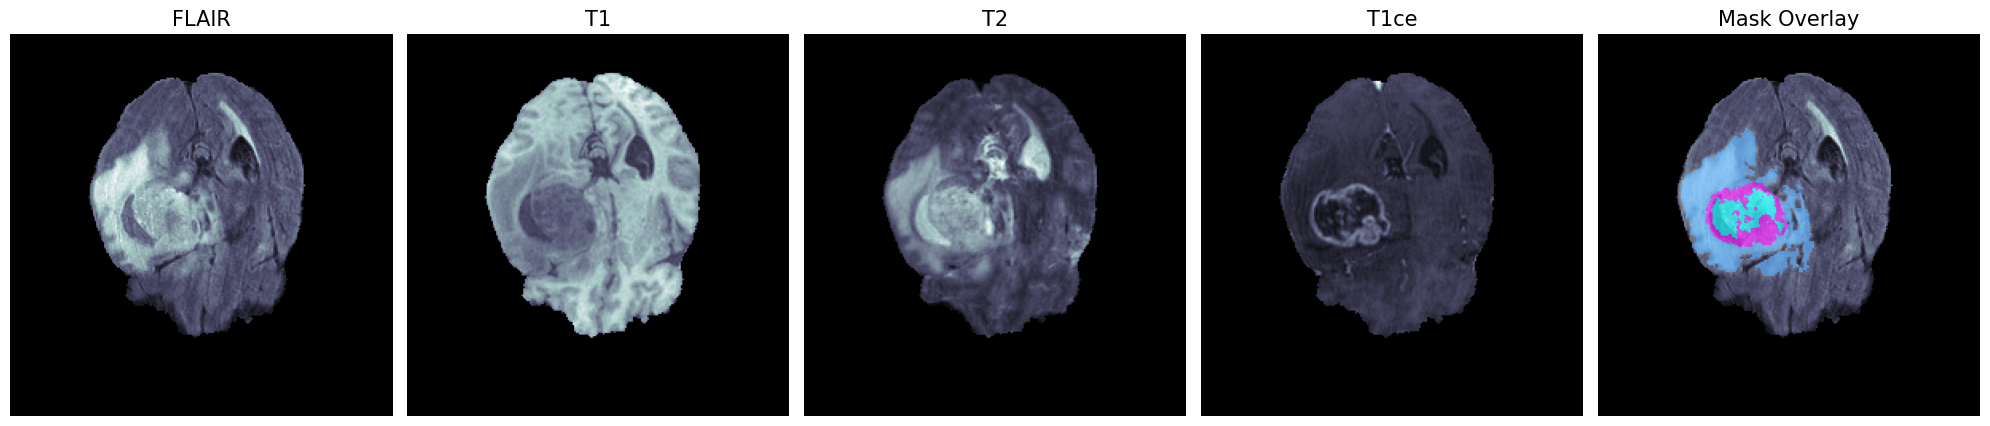

In [4]:
def explore_initial_data(root_dir):
    patient_id = 'BraTS20_Training_001'
    base_path = f'{root_dir}/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/{patient_id}/{patient_id}'
    
    file_paths = {
        'flair': f'{base_path}_flair.nii',
        't1': f'{base_path}_t1.nii',
        't2': f'{base_path}_t2.nii',
        't1ce': f'{base_path}_t1ce.nii',
        'mask': f'{base_path}_seg.nii'
    }

    def load_and_rot(path):
        img = nib.load(path)
        img = np.asanyarray(img.dataobj)
        return np.rot90(img)

    images = {key: load_and_rot(path) for key, path in file_paths.items()}

    fig = plt.figure(figsize=(20, 5))
    gs = gridspec.GridSpec(nrows=1, ncols=5)
    slice_idx = 65

    plot_titles = ['FLAIR', 'T1', 'T2', 'T1ce', 'Mask Overlay']
    image_keys = ['flair', 't1', 't2', 't1ce', 'flair']

    for i, (title, key) in enumerate(zip(plot_titles, image_keys)):
        ax = fig.add_subplot(gs[0, i])
        ax.imshow(images[key][:, :, slice_idx], cmap='bone')
        if title == 'Mask Overlay':
            mask_overlay = np.ma.masked_where(images['mask'][:, :, slice_idx] == 0, images['mask'][:, :, slice_idx])
            ax.imshow(mask_overlay, cmap='cool', alpha=0.6)
        ax.set_title(title, fontsize=15)
        ax.set_axis_off()

    plt.tight_layout()
    plt.savefig('../working/data_sample.png')
    plt.show()
    
explore_initial_data('../input/brats20-dataset-training-validation')

# 3. TIỀN XỬ LÝ DỮ LIỆU

In [5]:
class GlobalConfig:
    data_root_dir = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
    path_to_csv = '../working/data.csv'
    seed = 69

def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

config = GlobalConfig()
seed_everything(config.seed)

In [6]:
def get_augmentations(phase):
    if phase == "train":
        return tio.Compose([
            tio.RandomAffine(
                degrees=3,
                scales=(0.95, 1.05),
                translation=2,
                p=0.5
            ),
            tio.RandomBlur(p=0.2),
            tio.RandomGamma(log_gamma=(-0.1, 0.1), p=0.2),
        ])
    else:
        return tio.Compose([])

def get_dataloader(dataset, path_to_csv, phase, batch_size=1, num_workers=2):
    df = pd.read_csv(path_to_csv)
    df_phase = df[df['split'] == phase].reset_index(drop=True)
    
    dataset_instance = dataset(df_phase, phase)
    is_train = phase == "train"
    
    return DataLoader(dataset_instance, batch_size=batch_size, num_workers=num_workers, pin_memory=True, shuffle=is_train)


In [7]:
def prepare_data(config):
    patient_ids = [d for d in os.listdir(config.data_root_dir) if os.path.isdir(os.path.join(config.data_root_dir, d))]
    df = pd.DataFrame(patient_ids, columns=['Brats20ID'])
    df['path'] = df['Brats20ID'].apply(lambda x: os.path.join(config.data_root_dir, x))
    df = df[df['Brats20ID'] != 'BraTS20_Training_355'].reset_index(drop=True)

    kf = KFold(n_splits=7, random_state=config.seed, shuffle=True)
    df['fold'] = -1
    for i, (train_idx, val_idx) in enumerate(kf.split(df)):
        df.loc[val_idx, 'fold'] = i
    
    df['split'] = 'train'
    df.loc[df['fold'] == 1, 'split'] = 'val'
    df.loc[df['fold'] == 0, 'split'] = 'test'

    df.to_csv(config.path_to_csv, index=False)
    
    print("Data preparation complete and saved to", config.path_to_csv)
    print(f"Total train samples: {len(df[df['split'] == 'train'])}")
    print(f"Total validation samples: {len(df[df['split'] == 'val'])}")
    print(f"Total test samples: {len(df[df['split'] == 'test'])}")
    return df

df = prepare_data(config)

Data preparation complete and saved to ../working/data.csv
Total train samples: 262
Total validation samples: 53
Total test samples: 53


In [8]:
class BratsDataset(Dataset):
    def __init__(self, df: pd.DataFrame, phase: str):
        self.df = df
        self.phase = phase
        self.transform = get_augmentations(phase)
        self.data_types = ['_flair.nii', '_t1.nii', '_t1ce.nii', '_t2.nii']
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        id_ = self.df.loc[idx, 'Brats20ID']
        root_path = self.df.loc[idx, 'path']
        
        images = []
        for data_type in self.data_types:
            img_path = os.path.join(root_path, id_ + data_type)
            img = self.load_img(img_path)
            img = self.normalize(img)
            images.append(img)
        
        img = np.stack(images)
        img = np.moveaxis(img, (0, 1, 2, 3), (0, 3, 2, 1))
        
        mask_path = os.path.join(root_path, id_ + "_seg.nii")
        mask = self.load_img(mask_path)
        mask = self.preprocess_mask_labels(mask)

        subject = tio.Subject(
            image=tio.ScalarImage(tensor=img),
            mask=tio.LabelMap(tensor=mask)
        )
        subject = self.transform(subject)
        img = subject['image'].data
        mask = subject['mask'].data

        return {
            "Id": id_,
            "image": img.float(),
            "mask": mask.float()
        }
    
    def load_img(self, file_path):
        data = nib.load(file_path)
        return np.asarray(data.dataobj, dtype=np.float32)
    
    def normalize(self, data: np.ndarray):
        data_min = np.min(data)
        data_max = np.max(data)
        return (data - data_min) / (data_max - data_min + 1e-9)
    
    def preprocess_mask_labels(self, mask: np.ndarray):
        mask_WT = (mask > 0).astype(np.float32)
        mask_TC = ((mask == 1) | (mask == 4)).astype(np.float32)
        mask_ET = (mask == 4).astype(np.float32)
        mask = np.stack([mask_WT, mask_TC, mask_ET])
        return np.moveaxis(mask, (0, 1, 2, 3), (0, 3, 2, 1))


# 4. KHAI BÁO MÔ HÌNH

In [9]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, num_groups=8):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(nn.MaxPool3d(2, 2), DoubleConv(in_channels, out_channels))
    def forward(self, x):
        return self.encoder(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()
        if trilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose3d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffZ, diffY, diffX = x2.size(2) - x1.size(2), x2.size(3) - x1.size(3), x2.size(4) - x1.size(4)
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2, diffZ // 2, diffZ - diffZ // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class Out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

class UNet3d(nn.Module):
    def __init__(self, in_channels, n_classes, n_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, n_channels)
        self.enc1 = Down(n_channels, 2 * n_channels)
        self.enc2 = Down(2 * n_channels, 4 * n_channels)
        self.enc3 = Down(4 * n_channels, 8 * n_channels)
        self.enc4 = Down(8 * n_channels, 8 * n_channels)
        self.dec1 = Up(16 * n_channels, 4 * n_channels)
        self.dec2 = Up(8 * n_channels, 2 * n_channels)
        self.dec3 = Up(4 * n_channels, n_channels)
        self.dec4 = Up(2 * n_channels, n_channels)
        self.out = Out(n_channels, n_classes)

    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        x5 = self.enc4(x4)
        mask = self.dec1(x5, x4)
        mask = self.dec2(mask, x3)
        mask = self.dec3(mask, x2)
        mask = self.dec4(mask, x1)
        return self.out(mask)

# 5. HUẤN LUYỆN & ĐÁNH GIÁ

In [10]:
class DiceLoss(nn.Module):
    def __init__(self, eps: float = 1e-9):
        super().__init__()
        self.eps = eps
    def forward(self, logits, targets):
        num = targets.size(0)
        prob = torch.sigmoid(logits)
        prob = prob.view(num, -1)
        targets = targets.view(num, -1)
        intersection = 2.0 * (prob * targets).sum()
        union = prob.sum() + targets.sum()
        return 1.0 - (intersection + self.eps) / (union + self.eps)

class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
    def forward(self, logits, targets):
        return self.bce(logits, targets) + self.dice(logits, targets)

class Meter:
    def __init__(self, threshold=0.5):
        self.threshold = threshold
        self.dice_scores_wt = []
        self.dice_scores_tc = []
        self.dice_scores_et = []

    def update(self, logits: torch.Tensor, targets: torch.Tensor):
        probs = torch.sigmoid(logits)
        preds = (probs > self.threshold).float()
        
        targets = targets.to(preds.device)
        
        self.dice_scores_wt.append(self.dice_coef(preds[:, 0], targets[:, 0]))
        self.dice_scores_tc.append(self.dice_coef(preds[:, 1], targets[:, 1]))
        self.dice_scores_et.append(self.dice_coef(preds[:, 2], targets[:, 2]))

    def dice_coef(self, preds, targets, eps=1e-9):
        intersection = 2.0 * (targets * preds).sum()
        union = targets.sum() + preds.sum()
        return ((intersection + eps) / (union + eps)).item()

    def get_metrics(self):
        dice_wt = np.mean(self.dice_scores_wt)
        dice_tc = np.mean(self.dice_scores_tc)
        dice_et = np.mean(self.dice_scores_et)
        avg_dice = np.mean([dice_wt, dice_tc, dice_et])
        return {
            "dice_avg": avg_dice,
            "dice_wt": dice_wt,
            "dice_tc": dice_tc,
            "dice_et": dice_et,
        }

In [11]:
def train_one_epoch(model, dataloader, optimizer, criterion, accumulation_steps, device):
    model.train()
    meter = Meter()
    running_loss = 0.0
    optimizer.zero_grad()
    
    for i, data_batch in enumerate(tqdm(dataloader, desc="Training")):
        images, targets = data_batch['image'].to(device), data_batch['mask'].to(device)
        
        logits = model(images)
        loss = criterion(logits, targets)
        loss = loss / accumulation_steps
        loss.backward()
        
        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            
        running_loss += loss.item()
        meter.update(logits.detach(), targets)
        
    epoch_loss = (running_loss * accumulation_steps) / len(dataloader)
    epoch_metrics = meter.get_metrics()
    return epoch_loss, epoch_metrics

def evaluate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    meter = Meter()
    running_loss = 0.0
    
    with torch.no_grad():
        for data_batch in tqdm(dataloader, desc="Validating"):
            images, targets = data_batch['image'].to(device), data_batch['mask'].to(device)
            logits = model(images)
            loss = criterion(logits, targets)
            running_loss += loss.item()
            meter.update(logits, targets)

    epoch_loss = running_loss / len(dataloader)
    epoch_metrics = meter.get_metrics()
    return epoch_loss, epoch_metrics

In [12]:
wandb.init(
    project="BraTS-Segmentation",
    config={
        "architecture": "3D U-Net", "dataset": "BraTS2020", "epochs": 40,
        "learning_rate": 5e-4, "batch_size": 1, "accumulation_steps": 4,
        "early_stopping_patience": 5
    },
    job_type="training"
)

w_config = wandb.config
model = UNet3d(in_channels=4, n_classes=3, n_channels=24)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

optimizer = Adam(model.parameters(), lr=w_config.learning_rate, weight_decay=1e-5)
criterion = BCEDiceLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=w_config.epochs, eta_min=1e-6)

train_loader = get_dataloader(BratsDataset, config.path_to_csv, "train", w_config.batch_size)
val_loader = get_dataloader(BratsDataset, config.path_to_csv, "val", w_config.batch_size)

best_loss = 99999
patience = w_config.early_stopping_patience
epochs_no_improve = 0

for epoch in range(w_config.epochs):
    print(f"--- Epoch {epoch+1}/{w_config.epochs} ---")
    train_loss, train_metrics = train_one_epoch(model, train_loader, optimizer, criterion, w_config.accumulation_steps, device)
    val_loss, val_metrics = evaluate_one_epoch(model, val_loader, criterion, device)
    
    scheduler.step()
    
    wandb.log({
        "train_loss": train_loss,
        "train_dice_avg": train_metrics["dice_avg"],
        "val_loss": val_loss,
        "val_dice_avg": val_metrics["dice_avg"],
        "learning_rate": scheduler.get_last_lr()[0], # Log learning rate
        "epoch": epoch
    })
    
    print(f'Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Dice Avg: {val_metrics["dice_avg"]:.4f}')
    
    if val_loss < best_loss:
        epochs_no_improve = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "../working/best_model.pth")
        print(f"Saved new best model with val_loss: {best_loss:.4f}")
    else:
        epochs_no_improve += 1
        print(f"Validation loss did not improve for {epochs_no_improve} epoch(s).")

    if epochs_no_improve == patience:
        print(f"Early stopping triggered after {patience} epochs.")
        break

model_artifact = wandb.Artifact('unet3d-model', type='model', metadata={"best_val_loss": best_loss})
model_artifact.add_file('../working/best_model.pth')
wandb.log_artifact(model_artifact)

data_artifact = wandb.Artifact('brats-dataset-files', type='dataset')
data_artifact.add_file(config.path_to_csv)
data_artifact.add_file('../working/data_sample.png')
wandb.log_artifact(data_artifact)

wandb.finish()

--- Epoch 1/40 ---


Validating: 100%|██████████| 53/53 [00:52<00:00,  1.01it/s]


Epoch 1 | Train Loss: 1.5046 | Val Loss: 1.4170 | Val Dice Avg: 0.3764
Saved new best model with val_loss: 1.4170
--- Epoch 2/40 ---


Validating: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]


Epoch 2 | Train Loss: 1.3571 | Val Loss: 1.3004 | Val Dice Avg: 0.4014
Saved new best model with val_loss: 1.3004
--- Epoch 3/40 ---


Validating: 100%|██████████| 53/53 [01:02<00:00,  1.19s/it]


Epoch 3 | Train Loss: 1.2493 | Val Loss: 1.2011 | Val Dice Avg: 0.4637
Saved new best model with val_loss: 1.2011
--- Epoch 4/40 ---


Validating: 100%|██████████| 53/53 [00:53<00:00,  1.01s/it]


Epoch 4 | Train Loss: 1.1552 | Val Loss: 1.1072 | Val Dice Avg: 0.5170
Saved new best model with val_loss: 1.1072
--- Epoch 5/40 ---


Validating: 100%|██████████| 53/53 [01:04<00:00,  1.21s/it]


Epoch 5 | Train Loss: 1.0671 | Val Loss: 1.0349 | Val Dice Avg: 0.5255
Saved new best model with val_loss: 1.0349
--- Epoch 6/40 ---


Validating: 100%|██████████| 53/53 [00:57<00:00,  1.08s/it]


Epoch 6 | Train Loss: 0.9914 | Val Loss: 0.9576 | Val Dice Avg: 0.4870
Saved new best model with val_loss: 0.9576
--- Epoch 7/40 ---


Validating: 100%|██████████| 53/53 [00:51<00:00,  1.03it/s]


Epoch 7 | Train Loss: 0.9223 | Val Loss: 0.8767 | Val Dice Avg: 0.5543
Saved new best model with val_loss: 0.8767
--- Epoch 8/40 ---


Validating: 100%|██████████| 53/53 [00:52<00:00,  1.01it/s]


Epoch 8 | Train Loss: 0.8294 | Val Loss: 0.7738 | Val Dice Avg: 0.6358
Saved new best model with val_loss: 0.7738
--- Epoch 9/40 ---


Validating: 100%|██████████| 53/53 [00:50<00:00,  1.05it/s]


Epoch 9 | Train Loss: 0.7193 | Val Loss: 0.6707 | Val Dice Avg: 0.6380
Saved new best model with val_loss: 0.6707
--- Epoch 10/40 ---


Validating: 100%|██████████| 53/53 [01:07<00:00,  1.28s/it]


Epoch 10 | Train Loss: 0.6039 | Val Loss: 0.5407 | Val Dice Avg: 0.6491
Saved new best model with val_loss: 0.5407
--- Epoch 11/40 ---


Validating: 100%|██████████| 53/53 [00:54<00:00,  1.03s/it]


Epoch 11 | Train Loss: 0.5040 | Val Loss: 0.4593 | Val Dice Avg: 0.6450
Saved new best model with val_loss: 0.4593
--- Epoch 12/40 ---


Validating: 100%|██████████| 53/53 [01:04<00:00,  1.22s/it]


Epoch 12 | Train Loss: 0.4160 | Val Loss: 0.3776 | Val Dice Avg: 0.6938
Saved new best model with val_loss: 0.3776
--- Epoch 13/40 ---


Validating: 100%|██████████| 53/53 [00:51<00:00,  1.03it/s]


Epoch 13 | Train Loss: 0.3585 | Val Loss: 0.3412 | Val Dice Avg: 0.6943
Saved new best model with val_loss: 0.3412
--- Epoch 14/40 ---


Validating: 100%|██████████| 53/53 [00:49<00:00,  1.06it/s]


Epoch 14 | Train Loss: 0.3272 | Val Loss: 0.3547 | Val Dice Avg: 0.6524
Validation loss did not improve for 1 epoch(s).
--- Epoch 15/40 ---


Validating: 100%|██████████| 53/53 [00:49<00:00,  1.08it/s]


Epoch 15 | Train Loss: 0.2965 | Val Loss: 0.2958 | Val Dice Avg: 0.7100
Saved new best model with val_loss: 0.2958
--- Epoch 16/40 ---


Validating: 100%|██████████| 53/53 [00:56<00:00,  1.07s/it]


Epoch 16 | Train Loss: 0.2748 | Val Loss: 0.2734 | Val Dice Avg: 0.7123
Saved new best model with val_loss: 0.2734
--- Epoch 17/40 ---


Validating: 100%|██████████| 53/53 [01:04<00:00,  1.22s/it]


Epoch 17 | Train Loss: 0.2535 | Val Loss: 0.2513 | Val Dice Avg: 0.7307
Saved new best model with val_loss: 0.2513
--- Epoch 18/40 ---


Validating: 100%|██████████| 53/53 [00:56<00:00,  1.06s/it]


Epoch 18 | Train Loss: 0.2417 | Val Loss: 0.2514 | Val Dice Avg: 0.7330
Validation loss did not improve for 1 epoch(s).
--- Epoch 19/40 ---


Validating: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]


Epoch 19 | Train Loss: 0.2342 | Val Loss: 0.2498 | Val Dice Avg: 0.7330
Saved new best model with val_loss: 0.2498
--- Epoch 20/40 ---


Validating: 100%|██████████| 53/53 [00:57<00:00,  1.08s/it]


Epoch 20 | Train Loss: 0.2210 | Val Loss: 0.2325 | Val Dice Avg: 0.7465
Saved new best model with val_loss: 0.2325
--- Epoch 21/40 ---


Validating: 100%|██████████| 53/53 [01:01<00:00,  1.16s/it]


Epoch 21 | Train Loss: 0.2179 | Val Loss: 0.2356 | Val Dice Avg: 0.7294
Validation loss did not improve for 1 epoch(s).
--- Epoch 22/40 ---


Validating: 100%|██████████| 53/53 [00:57<00:00,  1.09s/it]


Epoch 22 | Train Loss: 0.2120 | Val Loss: 0.2151 | Val Dice Avg: 0.7566
Saved new best model with val_loss: 0.2151
--- Epoch 23/40 ---


Validating: 100%|██████████| 53/53 [00:57<00:00,  1.09s/it]


Epoch 23 | Train Loss: 0.2125 | Val Loss: 0.2285 | Val Dice Avg: 0.7432
Validation loss did not improve for 1 epoch(s).
--- Epoch 24/40 ---


Validating: 100%|██████████| 53/53 [00:54<00:00,  1.03s/it]


Epoch 24 | Train Loss: 0.2056 | Val Loss: 0.2174 | Val Dice Avg: 0.7573
Validation loss did not improve for 2 epoch(s).
--- Epoch 25/40 ---


Validating: 100%|██████████| 53/53 [01:00<00:00,  1.14s/it]


Epoch 25 | Train Loss: 0.1989 | Val Loss: 0.2057 | Val Dice Avg: 0.7645
Saved new best model with val_loss: 0.2057
--- Epoch 26/40 ---


Validating: 100%|██████████| 53/53 [00:52<00:00,  1.01it/s]


Epoch 26 | Train Loss: 0.1936 | Val Loss: 0.2016 | Val Dice Avg: 0.7619
Saved new best model with val_loss: 0.2016
--- Epoch 27/40 ---


Validating: 100%|██████████| 53/53 [00:55<00:00,  1.04s/it]


Epoch 27 | Train Loss: 0.1909 | Val Loss: 0.2012 | Val Dice Avg: 0.7673
Saved new best model with val_loss: 0.2012
--- Epoch 28/40 ---


Validating: 100%|██████████| 53/53 [00:52<00:00,  1.02it/s]


Epoch 28 | Train Loss: 0.1898 | Val Loss: 0.2045 | Val Dice Avg: 0.7620
Validation loss did not improve for 1 epoch(s).
--- Epoch 29/40 ---


Validating: 100%|██████████| 53/53 [00:54<00:00,  1.03s/it]


Epoch 29 | Train Loss: 0.1869 | Val Loss: 0.2002 | Val Dice Avg: 0.7668
Saved new best model with val_loss: 0.2002
--- Epoch 30/40 ---


Validating: 100%|██████████| 53/53 [00:54<00:00,  1.03s/it]


Epoch 30 | Train Loss: 0.1813 | Val Loss: 0.1996 | Val Dice Avg: 0.7720
Saved new best model with val_loss: 0.1996
--- Epoch 31/40 ---


Validating: 100%|██████████| 53/53 [00:53<00:00,  1.01s/it]


Epoch 31 | Train Loss: 0.1839 | Val Loss: 0.1960 | Val Dice Avg: 0.7730
Saved new best model with val_loss: 0.1960
--- Epoch 32/40 ---


Validating: 100%|██████████| 53/53 [00:53<00:00,  1.00s/it]


Epoch 32 | Train Loss: 0.1783 | Val Loss: 0.1942 | Val Dice Avg: 0.7718
Saved new best model with val_loss: 0.1942
--- Epoch 33/40 ---


Validating: 100%|██████████| 53/53 [01:02<00:00,  1.17s/it]


Epoch 33 | Train Loss: 0.1753 | Val Loss: 0.1921 | Val Dice Avg: 0.7714
Saved new best model with val_loss: 0.1921
--- Epoch 34/40 ---


Validating: 100%|██████████| 53/53 [01:17<00:00,  1.47s/it]


Epoch 34 | Train Loss: 0.1735 | Val Loss: 0.1923 | Val Dice Avg: 0.7723
Validation loss did not improve for 1 epoch(s).
--- Epoch 35/40 ---


Validating: 100%|██████████| 53/53 [01:00<00:00,  1.15s/it]


Epoch 35 | Train Loss: 0.1720 | Val Loss: 0.1917 | Val Dice Avg: 0.7730
Saved new best model with val_loss: 0.1917
--- Epoch 36/40 ---


Validating: 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]


Epoch 36 | Train Loss: 0.1716 | Val Loss: 0.1901 | Val Dice Avg: 0.7746
Saved new best model with val_loss: 0.1901
--- Epoch 37/40 ---


Validating: 100%|██████████| 53/53 [01:04<00:00,  1.23s/it]


Epoch 37 | Train Loss: 0.1702 | Val Loss: 0.1892 | Val Dice Avg: 0.7752
Saved new best model with val_loss: 0.1892
--- Epoch 38/40 ---


Validating: 100%|██████████| 53/53 [01:00<00:00,  1.14s/it]


Epoch 38 | Train Loss: 0.1699 | Val Loss: 0.1892 | Val Dice Avg: 0.7758
Saved new best model with val_loss: 0.1892
--- Epoch 39/40 ---


Validating: 100%|██████████| 53/53 [01:00<00:00,  1.15s/it]


Epoch 39 | Train Loss: 0.1708 | Val Loss: 0.1898 | Val Dice Avg: 0.7750
Validation loss did not improve for 1 epoch(s).
--- Epoch 40/40 ---


Validating: 100%|██████████| 53/53 [00:54<00:00,  1.03s/it]


Epoch 40 | Train Loss: 0.1694 | Val Loss: 0.1897 | Val Dice Avg: 0.7748
Validation loss did not improve for 2 epoch(s).


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,██████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
train_dice_avg,▁▃▃▄▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇█████████████████████
train_loss,█▇▇▆▆▅▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_dice_avg,▁▁▃▃▄▃▄▆▆▆▆▇▇▆▇▇▇▇▇▇▇█▇█████████████████
val_loss,█▇▇▆▆▅▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,39
learning_rate,0.0
train_dice_avg,0.77506
train_loss,0.16944
val_dice_avg,0.7748


# 6. KẾT QUẢ

In [13]:
def plot_comparison(image, ground_truth, prediction, save_path):
    image = image.squeeze().cpu().numpy()[0]
    gt = ground_truth.squeeze().cpu().numpy()
    pred = prediction.squeeze().cpu().numpy()

    image_montage = np.rot90(montage(image))
    gt_montage = np.rot90(montage(gt[0] + gt[1] + gt[2]))
    pred_montage = np.rot90(montage(pred[0] + pred[1] + pred[2]))

    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    axes[0].imshow(image_montage, cmap='bone')
    axes[0].imshow(np.ma.masked_where(gt_montage == 0, gt_montage), cmap='cool', alpha=0.7)
    axes[0].set_title("Ground Truth", fontsize=20)
    axes[0].axis('off')

    axes[1].imshow(image_montage, cmap='bone')
    axes[1].imshow(np.ma.masked_where(pred_montage == 0, pred_montage), cmap='cool', alpha=0.7)
    axes[1].set_title("Prediction", fontsize=20)
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

def create_slice_gif(image_volume, mask_volume, filename):
    image = image_volume.squeeze().cpu().numpy()[0]
    mask = mask_volume.squeeze().cpu().numpy()
    mask = mask[0] + mask[1] + mask[2]
    frames = []
    for i in range(image.shape[0]):
        fig, ax = plt.subplots(figsize=(6, 6))
        image_slice = image[i, :, :]
        mask_slice = mask[i, :, :]
        
        ax.imshow(np.rot90(image_slice), cmap='bone')
        ax.imshow(np.ma.masked_where(np.rot90(mask_slice) == 0, np.rot90(mask_slice)), cmap='cool', alpha=0.6)
        ax.set_title(f"Slice {i+1}/{image.shape[0]}", fontsize=15)
        ax.axis('off')
        
        fig.canvas.draw()
        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(frame)
        plt.close(fig)
    
    imageio.mimsave(filename, frames, fps=10)
    print(f"Vertical GIF saved to {filename}")

def plot_tumor_3d(mask_volume, filename):
    mask = mask_volume.squeeze().cpu().numpy()
    wt, tc, et = mask[0], mask[1], mask[2]
    
    def get_coords(mask_slice):
        z, x, y = (mask_slice > 0.5).nonzero()
        return x, y, z
    
    x_wt, y_wt, z_wt = get_coords(wt)
    x_tc, y_tc, z_tc = get_coords(tc)
    x_et, y_et, z_et = get_coords(et)
    
    fig = go.Figure(data=[
        go.Scatter3d(x=x_et, y=y_et, z=z_et, mode='markers', marker=dict(size=2, color='red'), name='Enhancing Tumor (ET)'),
        go.Scatter3d(x=x_tc, y=y_tc, z=z_tc, mode='markers', marker=dict(size=2, color='yellow'), name='Tumor Core (TC)'),
        go.Scatter3d(x=x_wt, y=y_wt, z=z_wt, mode='markers', marker=dict(size=2, color='cyan', opacity=0.2), name='Whole Tumor (WT/Edema)'),
    ])
    fig.update_layout(title_text="3D Tumor Visualization")
    fig.write_html(file=filename, auto_open=False)
    print(f"3D plot saved to {filename}")

class ComprehensiveMeter:
    def __init__(self, threshold=0.5):
        self.threshold = threshold
        self.epsilon = 1e-9
        self.tp = [0, 0, 0]
        self.tn = [0, 0, 0]
        self.fp = [0, 0, 0]
        self.fn = [0, 0, 0]

    def update(self, logits: torch.Tensor, targets: torch.Tensor):
        probs = torch.sigmoid(logits)
        preds = (probs > self.threshold).int()
        targets = targets.int()
        
        for i in range(targets.shape[1]):
            pred_class = preds[:, i].flatten()
            target_class = targets[:, i].flatten()
            
            self.tp[i] += ((pred_class == 1) & (target_class == 1)).sum().item()
            self.tn[i] += ((pred_class == 0) & (target_class == 0)).sum().item()
            self.fp[i] += ((pred_class == 1) & (target_class == 0)).sum().item()
            self.fn[i] += ((pred_class == 0) & (target_class == 1)).sum().item()

    def get_metrics(self):
        results = {}
        class_names = ['wt', 'tc', 'et']
        all_dice = []
        
        for i, name in enumerate(class_names):
            tp, tn, fp, fn = self.tp[i], self.tn[i], self.fp[i], self.fn[i]
            
            accuracy = (tp + tn) / (tp + tn + fp + fn + self.epsilon)
            precision = tp / (tp + fp + self.epsilon)
            sensitivity_recall = tp / (tp + fn + self.epsilon)
            specificity = tn / (tn + fp + self.epsilon)
            f1 = (2 * precision * sensitivity_recall) / (precision + sensitivity_recall + self.epsilon)
            dice = (2 * tp) / (2 * tp + fp + fn + self.epsilon)
            
            results[f'test_accuracy_{name}'] = accuracy
            results[f'test_precision_{name}'] = precision
            results[f'test_recall_sensitivity_{name}'] = sensitivity_recall
            results[f'test_specificity_{name}'] = specificity
            results[f'test_f1_score_{name}'] = f1
            results[f'test_dice_score_{name}'] = dice
            all_dice.append(dice)
            
        results['test_dice_avg'] = np.mean(all_dice)
        return results
def remove_small_regions(mask_tensor, min_size=100):
    mask_np = mask_tensor.squeeze().cpu().numpy()
    cleaned_mask = np.zeros_like(mask_np)
    
    for i in range(mask_np.shape[0]):
        channel_mask = mask_np[i]
        labeled_mask, num_labels = label(channel_mask, connectivity=3, return_num=True)
        
        for j in range(1, num_labels + 1):
            region = (labeled_mask == j)
            if np.sum(region) > min_size:
                cleaned_mask[i][region] = 1
                    
    return torch.from_numpy(cleaned_mask).unsqueeze(0)

In [14]:
wandb.init(project="BraTS-Segmentation", job_type="final_evaluation", name="test-run-with-all-metrics")

model_eval = UNet3d(in_channels=4, n_classes=3, n_channels=24)
model_eval.load_state_dict(torch.load('../working/best_model.pth'))
# model_eval.load_state_dict(torch.load('../input/model1/best_model.pth'))

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_eval.to(device)
model_eval.eval()

test_loader = get_dataloader(BratsDataset, config.path_to_csv, "test")
test_meter = ComprehensiveMeter()

print("--- Testing ---")
with torch.no_grad():
    for data_batch in tqdm(test_loader, desc="Testing"):
        images, targets = data_batch['image'].to(device), data_batch['mask']
        logits = model_eval(images)
        
        preds_raw = (torch.sigmoid(logits) > 0.5).float().cpu()
        cleaned_preds = remove_small_regions(preds_raw, min_size=100)
        
        test_meter.update(cleaned_preds, targets)

test_metrics = test_meter.get_metrics()

print("\\n--- Evaluation Complete ---")
print(f"Overall Dice Score (Average): {test_metrics['test_dice_avg']:.4f}")

class_names_full = {"wt": "Whole Tumor", "tc": "Tumor Core", "et": "Enhancing Tumor"}
for name in ['wt', 'tc', 'et']:
    print(f"\\n--- Metrics for class: {class_names_full[name]} ---")
    print(f"  - Accuracy:    {test_metrics[f'test_accuracy_{name}']:.4f}")
    print(f"  - Precision:   {test_metrics[f'test_precision_{name}']:.4f}")
    print(f"  - Recall/Sensitivity: {test_metrics[f'test_recall_sensitivity_{name}']:.4f}")
    print(f"  - Specificity: {test_metrics[f'test_specificity_{name}']:.4f}")
    print(f"  - F1 Score:    {test_metrics[f'test_f1_score_{name}']:.4f}")
    print(f"  - Dice Score:  {test_metrics[f'test_dice_score_{name}']:.4f}")

wandb.summary.update(test_metrics)

--- Testing ---


Testing: 100%|██████████| 53/53 [02:26<00:00,  2.76s/it]

\n--- Evaluation Complete ---
Overall Dice Score (Average): 0.8173
\n--- Metrics for class: Whole Tumor ---
  - Accuracy:    0.9974
  - Precision:   0.9120
  - Recall/Sensitivity: 0.8864
  - Specificity: 0.9989
  - F1 Score:    0.8990
  - Dice Score:  0.8990
\n--- Metrics for class: Tumor Core ---
  - Accuracy:    0.9975
  - Precision:   0.7884
  - Recall/Sensitivity: 0.7121
  - Specificity: 0.9990
  - F1 Score:    0.7483
  - Dice Score:  0.7483
\n--- Metrics for class: Enhancing Tumor ---
  - Accuracy:    0.9992
  - Precision:   0.7562
  - Recall/Sensitivity: 0.8594
  - Specificity: 0.9994
  - F1 Score:    0.8045
  - Dice Score:  0.8045


In [15]:
test_df = df[df['split'] == 'test'].reset_index(drop=True)
test_dataset = BratsDataset(test_df, phase='test')

patient_idx_to_visualize = 15

sample = test_dataset[patient_idx_to_visualize]
image, target = sample['image'].unsqueeze(0), sample['mask'].unsqueeze(0)

with torch.no_grad():
    logits = model_eval(image.to(device))
    preds_raw = (torch.sigmoid(logits) > 0.5).float().cpu()
    preds_cleaned = remove_small_regions(preds_raw, min_size=100)

comparison_path = f'../working/comparison_patient_{patient_idx_to_visualize}.png'
gif_path_pred = f'../working/gif_patient_{patient_idx_to_visualize}_pred.gif'
gif_path_gt = f'../working/gif_patient_{patient_idx_to_visualize}_gt.gif'
plot3d_path_pred = f'../working/3d_patient_{patient_idx_to_visualize}_pred.html'
plot3d_path_gt = f'../working/3d_patient_{patient_idx_to_visualize}_gt.html'

plot_comparison(image, target, preds_cleaned, comparison_path)
create_slice_gif(image, preds_cleaned, gif_path_pred)
create_slice_gif(image, target, gif_path_gt)
plot_tumor_3d(preds_cleaned, plot3d_path_pred)
plot_tumor_3d(target, plot3d_path_gt)

print(f"visualizations for patient {patient_idx_to_visualize} have been saved.")

wandb.log({
    "Final_Comparison": wandb.Image(comparison_path),
    "Final_Prediction_GIF_Prediction": wandb.Video(gif_path_pred, fps=10, format="gif"),
    "Final_Prediction_GIF_Ground_truth": wandb.Video(gif_path_gt, fps=10, format="gif"),
    "Final_3D_Plot_Prediction": wandb.Html(plot3d_path_pred),
    "Final_3D_Plot_Gound_truth": wandb.Html(plot3d_path_gt)
})

wandb.finish()


Vertical GIF saved to ../working/gif_patient_15_pred.gif
Vertical GIF saved to ../working/gif_patient_15_gt.gif


wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.


3D plot saved to ../working/3d_patient_15_pred.html
3D plot saved to ../working/3d_patient_15_gt.html
visualizations for patient 15 have been saved.


wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.


test_accuracy_et,0.99916
test_accuracy_tc,0.99752
test_accuracy_wt,0.99744
test_dice_avg,0.81726
test_dice_score_et,0.8045
test_dice_score_tc,0.74829
test_dice_score_wt,0.899
test_f1_score_et,0.8045
test_f1_score_tc,0.74829
test_f1_score_wt,0.899
test_precision_et,0.75618
